# Tutorial

For any issues please refer refer to the bibliography in the README or reach me out by email.

In [1]:
# Required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns
from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib


C:\Users\ac252489\AppData\Local\Temp\ipykernel_13308\1559852708.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# 
# Importing functions 
from import_excel import import_excel

from calc_translations import translate_mother_wavelets
from wavelet_decomposition import compute_wavelet_coefficient_betas
from wavelet_decomposition import preplotprocessing
from wavelet_decomposition import reconstruct

from plots import plot_betas_heatmap
from plots import plot_EPN
from calc_EPN import calc_epn
from plots import fft

### Importing Time Series

In [3]:
# Specipy the number of data per day of your time serie : dpd
# Specipy the number of day per year of your time serie : dpu
dpd = 48 # data per year
dpy = 365 # data per year :  cut the leap years to 365 years


# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 64 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

#
# Directory path
path_input_data = 'input_time_series/'
file_name = 'PV_2017.xlsx'

In [35]:
PV_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day
years = ['2017'] # Reste d'un code plus complexe. Cette entrée est nécessaire pour l'instant pour le calcul des coefficients de décomposition en ondelette. Il faudra sans doute le faire évoluer par la suite pour nos besoins.

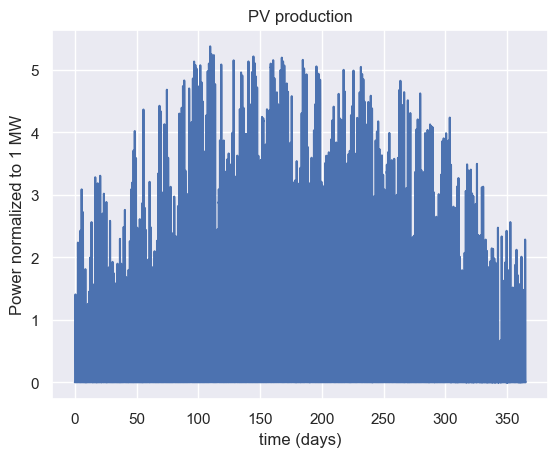

In [5]:
sns.set() # Set upa nice layout for all plots
time = np.arange(0,dpy,1./(ndpd))
plt.figure()
plt.plot(time, PV_ts)
plt.title('PV production')
plt.xlabel('time (days)')
plt.ylabel('Power normalized to 1 MW')
plt.show()


# Starting the wavelet decomposition

<br />

Signal is decomposed over a set of wavelets of 15 time scales :  [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] hours
              
The time scale could be understood as the duration of charge-discharge of a storage device

<br />

<ins>This set of wavelets is built such that:</ins>



- There is 3 mother wavelets with different durations : _Year_ , _Week_ and _Day_
<br />

- Those 3 wavelets have a physical meaning and account for human and season cycles. Therefore, we want to make sure that the year time scale is properly center over the year (summer un summer and winter in winter), that dayly wavelets are starting from 12pm to 12 pm and not 5am to 5am,...
<br />

- For this  reason we should compute and use translations, as shown in the cell below
<br />

- The mother wavelets are then divided in daugther wavelets

<br />

The 3 mother wavelets have to be adjusted on the signal: the _year_ should fit on the seasonal fluctuation, the _week_ on the week and weekend cycle, the _day_ on the nigh / day cycle
    * Translations are computed with the "Consumption signal" for each year
    * The same translations are reused for for the other time series

## Definition of the wavelet decomposition parameters

There are 3 mother wavelets of different timescale :
 * Year
 * Week
 * Day

They have been chosen beacause the reflect either human rythmes and/or nadural cycles : day and night, winter/summer, weekend and week days, etc.

Each of those mother wavelets are divided into shorter wavelets, as defined below :

In [6]:
#
# Options of the wavelet decomposition
vy = 6  # number of vectors per years (child wavelets)
vw = 3  # vectors per week
vd = 6  # vectors per day
#
# Time scales of the wavelet decomposition
# We define here the 15 time steps of the 'rich disctionnary' wavelets
time_scales = [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] # cycles length, in hours

In [7]:
# ------- To add somewhere at some point -------



load_factor = 54e+3 # MW
#Mean value of electricity load

### Presentation of the translate_mother_wavelets() function:

- Each mother wavelet needs to be translated to make sure that they are properly overlaping the right period : a day must strat at midnigh, a week on monday, the year in between the winter/summer season.

In [32]:
# ----------------------------------
# ------ Translations ------------
# ----------------------------------
'''
To perform a wavelet decomposition :
- We first need to compute or import translations. The calculatio could take a while...
'''
path_trans = 'translation' # T# Path where translations are saved once calculated
wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
input_data = PV_ts

# Check if the file exists
path_trans = 'translation/'
filename_pkl = os.path.join(os.getcwd(), path_trans, 'results_translation.pkl')

if os.path.exists(filename_pkl):
    print(f"Loading existing translation file: {filename_pkl}")
    # Load the data from the 'results_translation.pkl' file
    with open(filename_pkl, 'rb') as file:
        trans = pkl.load(file)

    
else:
    print("Computing translation...")
    # Calculate the translation
    trans = translate_mother_wavelets(ndpd, dpy, input_data, wl_shape='square')

    # Save the results of the translation in the 'translation/' directory
    with open(filename_pkl, 'wb') as file:
        pkl.dump(trans, file)

Loading existing translation file: c:\Users\ac252489\wavelet_decomposition\translation/results_translation.pkl


In [36]:
# ----------------------------------------------------
# ------ Performing wavelet decomposition ------------
# ----------------------------------------------------
'''
Second, we compute the coefficients of the wavelet decomposition
- wl_shape : either 'sine' or 'square' shape
- To compute new matrix use imp_matrix = False. It can take quite some time !
'''
path_matrix = "saved_matrix\\square_shape\\"
stacked_betas_square, saved_sheets_square = compute_wavelet_coefficient_betas(time_series, stacked_input_data,
                 vy, vw, vd, dpy, ndpd, years,
                 trans,
                 path_matrix,
                 beta_path, wl_shape ='square', imp_matrix = True)

pkl.dump([stacked_betas_square, saved_sheets_square], open('betas_saved_square' + '.p', "wb"))

# [stacked_betas_square, saved_sheets_square] = pkl.load(open('betas_saved_square' + '.p', "rb"))

NameError: name 'compute_wavelet_coefficient_betas' is not defined

In [ ]:
# df = preplotprocessing(vy, vw , vd, ndpd, dpy, signal, #Then the kind of signal. In this tutorial its either 'Consommation', 'Eolien' or 'Solaire
#                       year, years,
#                       saved_sheets_square, # Here is the datasheet you want to plot. This datasheet is returned by the function compute_betas(). Here is ploted the square decomposition
#                       do_trans = None) # Eventualy retranslate the decomposition to make it feet to the week, day and sesonal cycles
# plot_betas_heatmap(df, signal, year , ndpd,
#                       cmin= -0.1,
#                       cmax= 0.1,
#                     ccenter = None)

In [ ]:
#
# The wavelet decomposition is saved in a disctionnary with the following sstructure:
print(saved_sheets_square.keys())
print(saved_sheets_square['Consumption'].keys())
print(saved_sheets_square['Consumption']["2012"][14]) # 14th time scale

# Plots


## Heatmaps

<br />

The wavelet decomposition can be depicted with a heatmaps.

<br />

Example in the cells below

In [ ]:
# First, select the year
year = '2018'
# The directory where the matrix is saved. In this case, we are using square matric
# Replace square by sine for the sine wavelet decomposition
path_matrix = "saved_matrix\\square_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
# The signal on which you want to process the wavelet decomposition : 'Consumption', 'Wind' or 'PV'
signal = 'Consumption'
# 
df= preplotprocessing(vy, vw , vd, ndpd, dpy, signal, #Then the kind of signal. In this tutorial its either 'Consommation', 'Eolien' or 'Solaire
                      year, years,
                      time_scales,
                      saved_sheets_square, # Here is the datasheet you want to plot. This datasheet is returned by the function compute_betas(). Here is ploted the square decomposition
                      matrix)

plot_betas_heatmap(df, signal, year , ndpd,
                      cmin= -0.1,
                      cmax= 0.1,
                    ccenter = None)

# Wavelet _Versus_ Fourier transform

In [ ]:
year='2018' # year of the decomposition
index = years.index(year)

signal = 'Consumption'

input_data = stacked_input_data[signal][signal_length*index:signal_length*(index+1)]
fft(ndpd, dpy, signal, year, input_data)

# Computing Energy, Power, and Nb of Cycles
<br/>

### From the coefficients betas of the wavelet decomposition, we can determine the flexibility required by the energy system

<br/>

***Satisfaction rate:*** Percentage of the time the consumption is satisfied. Examples:
* If satisfaction rate = 90%: At the day scales 0.9*365=328 days per year, the energy demand will be satisfied. We get rid of the 365-328=37 days with the highest electricity consumption
* Here the signal last 7 years. With a 90% satisfaction rate we get rid of the 37*7 extreme days over the last 7 years

In [ ]:
# An example for an extreme case : 100% of electricity is produced by PV
scenario_name = 'PV'
conso = stacked_betas_square['Consumption']
prod =  stacked_betas_square['PV']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100] # Satisfaction rate
# Percentage of the time the load will be met by the storage device.

satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

# Reconstructing and filtering signals

In [ ]:
#
# Importing Matrix for the reconstruction
year = '2013'

path_matrix = "saved_matrix\\square_shape\\"
# path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
# #
reconstruct(time_scales, [12, 24],
                matrix,saved_sheets_square['PV'][year], "2013 PV signal filtered with 12h and 24h square wavelets",
                xmin=150, xmax=154,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, [24],
                matrix,saved_sheets_square['PV'][year], "2013 PV signal filtered with 24h square wavelets",
                xmin=150, xmax=154,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_square['PV'][year], "Reconstructed PV signal",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

# To translate or not translate ?
<br/>
<center> <bold> Results comparison with translations and without translations </bold></center>

In [ ]:
# -----------------------------------------------
# ------ Create translations full of zeros -----
# -----------------------------------------------
zero_trans = []
Nyears = int(len(stacked_input_data['Consumption'])/(ndpd*dpy) )
for i in range(Nyears):
    zero_trans.append([0,0,0])
    
# ----------------------------------------------------
# ------ Decomposition with without translations -----
# ----------------------------------------------------

path_matrix = "saved_matrix\\square_shape\\no_trans\\"
beta_path = "betas\\square_shape_no_trans\\"

stacked_betas_square_no_trans, saved_sheets_square_no_trans = compute_wavelet_coefficient_betas(time_series, stacked_input_data,
                 vy, vw, vd, dpy, ndpd, years,
                 zero_trans,
                 path_matrix,
                 beta_path, wl_shape ='square', imp_matrix = True)

pkl.dump([stacked_betas_square_no_trans, saved_sheets_square_no_trans], open('betas_saved_square_no_trans' + '.p', "wb"))

# [stacked_betas_square_no_trans, saved_sheets_square_no_trans] = pkl.load(open('betas_saved_square_no_trans' + '.p', "rb"))

In [ ]:
# --------------------------------------
# -- Same plots without translations ---
# --------------------------------------
scenario_name = 'PV, square wavelet decomposition without translation'
conso = stacked_betas_square_no_trans['Consumption']
prod =  stacked_betas_square_no_trans['PV']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_square_PV_no_trans = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results_square_PV_no_trans['emax'], results_square_PV_no_trans['pmax'], results_square_PV_no_trans['n'], results_square_PV_no_trans['uf'], results_square_PV_no_trans['serv'],
         time_scales, satisfactions, scenario_name )

# Sine and square shape wavelets
<br/>
Wavelets can take various shapes. We used here both sine and square shape. Here is and example of a sine shape decomposition

In [ ]:
# -------- Import translations -----
trans_file = 'trans_sine_12_18'

trans_sine = load_trans(path_trans, trans_file,
                   stacked_input_data, 'Consommation',
                   ndpd, dpy, 
                   'sine', do_calc=False)
# ------Perform wavelet decomposition ----

beta_path = "betas\\sine_shape\\"

path_matrix = "saved_matrix\\sine_shape\\"

stacked_betas_sine, saved_sheets_sine = compute_wavelet_coefficient_betas(time_series, stacked_input_data,
                 vy,vw,vd,dpy, ndpd, years,
                 trans_sine,
                 path_matrix,
                 beta_path, wl_shape ='sine', imp_matrix = True)

# ----- Plot 100% PV scenario ---

scenario_name = 'PV, sine wavelet decomposition'
sine_conso = stacked_betas_sine['Consumption']
sine_prod =  stacked_betas_sine['PV']

sine_pmc = [np.array(sine_prod[i]) - np.array(sine_conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_sine = calc_epn(sine_pmc, satisfactions, time_scales, dpy, load_factor, shape = 'sine')

In [ ]:
plot_EPN(results_sine['emax'], results_sine['pmax'], results_sine['n'], results_sine['uf'], results_sine['serv'],
         time_scales, satisfactions, scenario_name )

In [ ]:
# -------- Reconstruct signal -----

year = '2013'
path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
# #
reconstruct(time_scales, [24],
                matrix,saved_sheets_sine['PV'][year], "Signal PV 2013 with 24 hours sine wavelets",
                xmin=0, xmax=15,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_sine['PV'][year], "2013 PV signal reconsruction",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)